<a href="https://colab.research.google.com/github/AnnaScibska/Deep_learning_flowers_data_set/blob/master/with_comments_almost_done_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hello,

This is my final model for dataset: [flower recognition - kaggle](https://www.kaggle.com/alxmamaev/flowers-recognition)

Max accuracy I was able to achive is 78%. 

In the dataset there's plany of pictures that are bad example: 
- person holding a tiny flower, 
- a bug sitting on the flower, where the flower is only a foggy background, 
- and the hardest of them all: a field of flowers - you have to take a close look to recognise which flower is on the particular picture,
- etc. 

So for the given dataset I think the result is not bad :)

I was struggling with the overfitting - I had huge drop of accuracy at the beginning when evaluating model after finishing training with 99% accuracy (hence validation during the training and training ceiling).

I gain some accuracy by adding additional convolution and pooling layers.

It help a lot to increase the dataset size by adding pictures flipped vertically.

I experimented with number of neurons in a layer, batch size, learning rate etc. and this is the best I could come up with.

Although it was fun :) I had to stop at one point.

## Imports

In [0]:
import tensorflow as tf
import numpy as np
import cv2
import math
import os
import pathlib

from matplotlib import pyplot as plt

## Upload data from kaggle

In [2]:
file = open('/content/kaggle.json', 'w')
file.write('{\"username\":\"freeanke\",\"key\":\"92b509cecb01045514b22adb0910675c\"}')
file.close()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip flowers-recognition

Streaming output truncated to the last 5000 lines.
  inflating: flowers/flowers/rose/11102341464_508d558dfc_n.jpg  
  inflating: flowers/flowers/rose/11233672494_d8bf0a3dbf_n.jpg  
  inflating: flowers/flowers/rose/11694025703_9a906fedc1_n.jpg  
  inflating: flowers/flowers/rose/118974357_0faa23cce9_n.jpg  
  inflating: flowers/flowers/rose/11944957684_2cc806276e.jpg  
  inflating: flowers/flowers/rose/12165480946_c4a3fe182d_n.jpg  
  inflating: flowers/flowers/rose/12202373204_34fb07205b.jpg  
  inflating: flowers/flowers/rose/12238827553_cf427bfd51_n.jpg  
  inflating: flowers/flowers/rose/12240165555_98625b1e88_n.jpg  
  inflating: flowers/flowers/rose/12240303_80d87f77a3_n.jpg  
  inflating: flowers/flowers/rose/12240577184_b0de0e53ea_n.jpg  
  inflating: flowers/flowers/rose/12243068283_ee4c2683e2_n.jpg  
  inflating: flowers/flowers/rose/12243069253_e512464095_n.jpg  
  inflating: flowers/flowers/rose/123128873_546b8b7355_n.jpg  
  inflating: flowers/flowers/rose/12323085443_8ac0

## Data pre-processing

In [0]:
img_size = 150

#===# creating dataset
def loading_loop(filepaths, flip=False):

  dataset = []
  labels = []

  for path in filepaths:
    dataset.append(process_image( './' + str(path), flip))
    labels.append(translate_label_from_str_to_int(str(path).split('/')[-2]))

    if len(labels)%500 == 0:
      print(str(len(labels)) + '/' + str(len(filepaths)))

  return [ dataset, labels ]

#===# processing one image
# loading the file
# optionally: flipping vertically
# resizing
# rescaling

def process_image(filepath, flip):
  img = 0
  try:
    img = cv2.imread( filepath, cv2.IMREAD_UNCHANGED)
    if flip:
      img = cv2.flip(img, 1)
    img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA)
    img = img/255
    
  except Exception as e:
    print(str(e))

  return img

#===# working around labels
def translate_label_from_str_to_int(str_label):
  labels = {
      "sunflower": 0,
      "rose": 1,
      "dandelion": 2,
      "daisy": 3,
      "tulip": 4
  }
  return labels.get(str_label)

def translate_label_from_int_to_str(int_label):
  labels = {
      0: "sunflower",
      1: "rose",
      2: "dandelion",
      3: "daisy",
      4: "tulip"
  }
  return labels.get(int_label)

## Import the files

In [0]:
data_dir = pathlib.Path('flowers/flowers')
file_arr = np.array(list(data_dir.glob('*/*.jpg')))

Load data

In [20]:
np.random.shuffle(file_arr)
datas = loading_loop(file_arr)

500/4323
1000/4323
1500/4323
2000/4323
2500/4323
3000/4323
3500/4323
4000/4323


Load data - pictures flipped vertically

In [5]:
np.random.shuffle(file_arr)
flipped_datas = loading_loop(file_arr, True)

500/4323
1000/4323
1500/4323
2000/4323
2500/4323
3000/4323
3500/4323
4000/4323


Join datasets

In [0]:
datas[0] = datas[0] + flipped_datas[0]
datas[1] = datas[1] + flipped_datas[1]

Divide dataset into training and testing part

In [0]:
xs = datas[0]
ys = datas[1]

ds_size = len(datas[0])

testData = xs[:ds_size:5]
testLabel = ys[:ds_size:5]

trainData = np.delete(xs, slice(0, ds_size, 5), 0)
trainLabel = np.delete(ys, slice(0, ds_size, 5))

Display test picture with label

sunflower


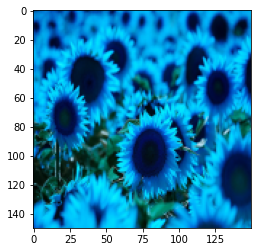

In [22]:
def gen_image(img):
    plt.imshow(img)
    return plt

nb = 500
print(translate_label_from_int_to_str(trainLabel[nb]))
gen_image(trainData[nb]).show()

## Creating, training and testing a model

In [0]:
#==# stopping the model from overfitting
class training_ceiling(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

In [0]:
epochs=100
batch_size=100

In [0]:
callbacks = training_ceiling()

In [0]:
model = tf.keras.models.Sequential([
                                    
    #===# image processing
    tf.keras.layers.Convolution2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape=(img_size,img_size,3)),                       
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    tf.keras.layers.Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    tf.keras.layers.Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    
    # tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    
    #===# creating neural network
    tf.keras.layers.Dense(512, activation= tf.nn.relu),


    #===# output
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

In [0]:
model = tf.keras.models.Sequential([
                                    
    #===# image processing
    tf.keras.layers.Convolution2D(32, (3,3), activation="relu", input_shape=(img_size,img_size,3)),                       
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    
    #===# creating neural network
    tf.keras.layers.Dense(64, activation= tf.nn.relu),
    tf.keras.layers.Dense(128, activation= tf.nn.relu),
    tf.keras.layers.Dense(64, activation= tf.nn.relu),

    #===# output
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

In [0]:
batch_size=128
epochs=50

# from keras.callbacks import ReduceLROnPlateau
# red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [0]:
datagen.fit(np.asarray(trainData))

In [0]:
model.compile(optimizer=tf.optimizers.Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [32]:
History = model.fit(
    datagen.flow(
        np.asarray(trainData),
        np.asarray(trainLabel), 
        batch_size=batch_size),
    epochs = epochs, 
    validation_data=(np.asarray(testData),
                     np.asarray(testLabel)),
    verbose = 1, steps_per_epoch=np.asarray(trainData).shape[0] // batch_size) # 
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/50
27/27 [==============================] - 18s 682ms/step - loss: 1.3847 - accuracy: 0.3738 - val_loss: 1.1957 - val_accuracy: 0.4694
Epoch 2/50
27/27 [==============================] - 18s 661ms/step - loss: 1.1964 - accuracy: 0.5018 - val_loss: 1.0751 - val_accuracy: 0.5908
Epoch 3/50
27/27 [==============================] - 17s 645ms/step - loss: 1.1760 - accuracy: 0.5228 - val_loss: 1.0233 - val_accuracy: 0.6035
Epoch 4/50
27/27 [==============================] - 17s 643ms/step - loss: 1.0023 - accuracy: 0.5955 - val_loss: 0.9597 - val_accuracy: 0.6254
Epoch 5/50
27/27 [==============================] - 18s 648ms/step - loss: 0.9192 - accuracy: 0.6363 - val_loss: 0.9478 - val_accuracy: 0.6382
Epoch 6/50
27/27 [==============================] - 17s 645ms/step - loss: 0.9381 - accuracy: 0.6450 - val_loss: 0.9108 - val_accuracy: 0.6601
Epoch 7/50
27/27 [==============================] - 17s 642ms/step - loss: 0.9656 - accuracy: 0.6294 - val_loss: 0.9772 - val_accuracy: 0.6277

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)       

In [0]:
model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
model.fit(
    np.asarray(trainData), 
    np.asarray(trainLabel), 
    validation_data=(np.asarray(testData),np.asarray(testLabel)), 
    epochs=epochs, 
    batch_size=batch_size, 
    callbacks=[callbacks])

Epoch 1/100
70/70 [==============================] - 13s 184ms/step - loss: 1.2406 - accuracy: 0.4626 - val_loss: 1.0045 - val_accuracy: 0.5942
Epoch 2/100
70/70 [==============================] - 12s 173ms/step - loss: 0.9521 - accuracy: 0.6317 - val_loss: 1.1940 - val_accuracy: 0.5514
Epoch 3/100
70/70 [==============================] - 12s 173ms/step - loss: 0.8172 - accuracy: 0.6838 - val_loss: 0.8216 - val_accuracy: 0.6884
Epoch 4/100
70/70 [==============================] - 12s 173ms/step - loss: 0.7120 - accuracy: 0.7285 - val_loss: 0.8294 - val_accuracy: 0.6751
Epoch 5/100
70/70 [==============================] - 12s 174ms/step - loss: 0.6110 - accuracy: 0.7671 - val_loss: 1.1494 - val_accuracy: 0.6017
Epoch 6/100
70/70 [==============================] - 12s 174ms/step - loss: 0.5685 - accuracy: 0.7828 - val_loss: 0.7999 - val_accuracy: 0.7058
Epoch 7/100
70/70 [==============================] - 13s 182ms/step - loss: 0.4561 - accuracy: 0.8297 - val_loss: 0.7620 - val_accuracy:

In [0]:
model.fit(
    np.asarray(trainData), 
    np.asarray(trainLabel), 
    validation_data=(np.asarray(testData),np.asarray(testLabel)), 
    epochs=epochs, 
    batch_size=batch_size, 
    callbacks=[callbacks])

Epoch 1/100
70/70 [==============================] - 3s 39ms/step - loss: 1.3158 - accuracy: 0.4173 - val_loss: 1.2676 - val_accuracy: 0.3925
Epoch 2/100
70/70 [==============================] - 3s 38ms/step - loss: 1.0625 - accuracy: 0.5564 - val_loss: 1.1146 - val_accuracy: 0.5139
Epoch 3/100
70/70 [==============================] - 3s 38ms/step - loss: 0.9406 - accuracy: 0.6284 - val_loss: 0.8647 - val_accuracy: 0.6590
Epoch 4/100
70/70 [==============================] - 3s 37ms/step - loss: 0.8504 - accuracy: 0.6751 - val_loss: 0.9435 - val_accuracy: 0.6422
Epoch 5/100
70/70 [==============================] - 3s 37ms/step - loss: 0.8019 - accuracy: 0.6969 - val_loss: 0.7690 - val_accuracy: 0.7092
Epoch 6/100
70/70 [==============================] - 3s 37ms/step - loss: 0.7380 - accuracy: 0.7218 - val_loss: 0.7820 - val_accuracy: 0.7023
Epoch 7/100
70/70 [==============================] - 3s 37ms/step - loss: 0.6907 - accuracy: 0.7470 - val_loss: 0.7874 - val_accuracy: 0.6942
Epoch 

## Evaluating the model

In [33]:
model.evaluate(np.asarray(testData), np.asarray(testLabel))

28/28 [==============================] - 1s 26ms/step - loss: 0.7454 - accuracy: 0.7353


[0.7453597187995911, 0.7352601289749146]